#### From Quarks to Cosmos with AI: Tutorial Day 4
---
# Field-level cosmological inference with IMNN + DELFI

by Lucas Makinen [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/Orcid-ID.png" alt="drawing" width="20"/>](https://orcid.org/0000-0002-3795-6933 "") [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/lucasmakinen?lang=en ""), Tom Charnock [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/Orcid-ID.png" alt="drawing" width="20"/>](https://orcid.org/0000-0002-7416-3107 "Redirect to orcid") [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/t_charnock?lang=en "")), Justin Alsing [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/Orcid-ID.png" alt="drawing" width="20"/>](https://scholar.google.com/citations?user=ICPFL8AAAAAJ&hl=en "Redirect to orcid"), and Ben Wandelt [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/bwandelt?lang=en "")

>read the paper: [on arXiv tomorrow !]

>get the code:  [https://github.com/tlmakinen/FieldIMNNs](https://github.com/tlmakinen/FieldIMNNs)



![full-diagram](https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/anim-diagram.png)
$\quad$

In this tutorial we will demonstrate Implicit Likelihood Inference (IFI) using Density Estimation Likelihood Free Inference (DELFI) with optimal nonlinear summaries obtained from an Information Maximising Neural Network (IMNN). The goal of the exercise will be to build posterior distributions for the cosmological parameters $\Omega_c$ and $\sigma_8$ *directly* from overdensity field simulations.

First we'll install the relevant libraries and walk through the simulation implementation. Then we'll build a neural IMNN compressor to generate two optimal summaries for our simulations. Finally, we'll use these summaries to build and train a Conditional Masked Autoregressive Flow, from which we'll construct our parameter posterior distributions.

### Q: Wait a second -- how do we know this works ?
If you're not convinced by our method by the end of this tutorial, we invite you to take a look at our [benchmarking tutorial with Gaussian fields from power spectra](https://www.aquila-consortium.org/doc/imnn/pages/examples/2d_field_inference/2d_field_inference.html), which is also runnable in-browser on [this Colab notebook](https://colab.research.google.com/drive/1_y_Rgn3vrb2rlk9YUDUtfwDv9hx774ZF#scrollTo=EW4H-R8I0q6n).

---
# HOW TO USE THIS NOTEBOOK

You will (most likely) be running this code using a free version of Google Colab. The code runs just like a Jupyter notebook (`shift` + `enter` or click the play button to run cells). There are some cells with lengthy infrastructure code that you need to run to proceed. These are clearly marked with <font color='lightgreen'>[run me]</font>. When you get to the challenge exercises, you are welcome to code some functions yourself. However, if you want to run the notebook end-to-end, solution code is presented in hidden cells below (again with the marker <font color='lightgreen'>[run me]</font>).

Some cells are not meant to be run here as a part of Quarks to Cosmos, but can be run (with a Colab Pro account) on your own.

---

# step 1: loading packages and setting up environment

1.  check that Colab is set to run on a GPU ! Go to `Runtime`>`change runtime type` and select `GPU` from the dropdown menu. Next, enable dark mode by going to `settings`>`Theme` and selecting `dark` (protect your eyes !)

2.   install packages. The current code relies on several libraries, namely `jax` and `tensorflow_probability`. However, we require both plain `tensorflow_probability` (`tfp`) and the experimental `tensorflow_probability.substrates.jax` (`tfpj`) packages for different parts of our inference 
3. for some Colab sessions, you may need to run the second cell so that `!pip install jax-cosmo` gets the package imported properly.

In [1]:
#@title set up environment <font color='lightgreen'>[RUN ME FIRST]</font>
%tensorflow_version 2.x
import tensorflow as tf
print('tf version', tf.__version__)

!pip install -q jax==0.2.11

!pip install -q tensorflow-probability

import tensorflow_probability as tfp
print('tfp version:', tfp.__version__)
tfd = tfp.distributions
tfb = tfp.bijectors

!pip install -q imnn 

!python -m pip install -q jax-cosmo

tf version 2.5.0
     |████████████████████████████████| 604kB 13.5MB/s 
tfp version: 0.13.0
     |████████████████████████████████| 133kB 14.5MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 286kB 15.8MB/s 


note: if the cell below fails for installing jax-cosmo, just run it again: Colab will rearrange the headings needed.

In [3]:
# now import all the required libraries
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import jax

print('jax version:', jax.__version__)

# for nn model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax


# tensorflow-prob VANILLA
tfd = tfp.distributions
tfb = tfp.bijectors

# tensorflow-prob-JAX
import tensorflow_probability.substrates.jax as tfpj

tfdj = tfpj.distributions
tfbj = tfpj.bijectors


# for imnn
import imnn
import imnn.lfi

print('IMNN version:', imnn.__version__)

# jax-cosmo module
!python -m pip install -q jax-cosmo
import jax_cosmo as jc
print('jax-cosmo version:', jc.__version__)

# matplotlib stuff
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
import seaborn as sns
sns.set()


rng = random.PRNGKey(2)

jax version: 0.2.11
IMNN version: 0.3.0
jax-cosmo version: 0.1rc7


In [4]:
from jax.config import config
config.update('jax_enable_x64', True)

make sure we're using 64-bit precision and running on a GPU !

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Cosmological Fields from the Eisenstein-Hu linear matter power spectrum
We're interested in extracting the cosmological parameters $\Omega_c$ and $\sigma_8$ *directly* from cosmological field pixels. To generate our simulations we'll need to install the library `jax-cosmo` to generate our differentiable model power spectra.

## choose fiducial model
To train our neural compression, we first need to choose a fiducial model to train the IMNN.


For example lets say that our fiducial cosmology has $\Omega_c=0.40$ and $\sigma_8=0.60$. This is *deliberately* far from, say, Planck parameters -- we want to investigate how our compression behaves if we don't know our universe's true parameters.

In [7]:
cosmo_params = jc.Planck15(Omega_c=0.40, sigma8=0.60)
θ_fid = np.array(
    [cosmo_params.Omega_c, 
     cosmo_params.sigma8], 
    dtype=np.float32)

n_params = θ_fid.shape[0]

Our power spectrum $P_{\rm LN}(k)$ is the linear matter power spectrum defined as

In [8]:
def P(k, A=0.40, B=0.60):
    cosmo_params = jc.Planck15(Omega_c=A, sigma8=B)
    return jc.power.linear_matter_power(cosmo_params, k)

and we can visualize it in $k$-space (small $k$ <=> big $r$, big $k$ <=> small $r$) :

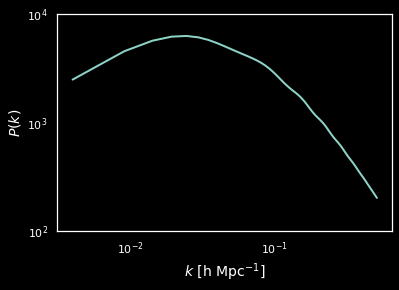

In [9]:
#@title plot the Eisenstein-Hu $P(k)$ <font color='lightgreen'>[run me]</font>

sns.set()
L = 250.
N = 128.
#kmax = 1.0
#kmin = 0.5 / (N)

kmax = N / L
kmin = 1. / L

kbin = np.linspace(kmin, kmax, num=100)

power_spec = P(kbin, A=cosmo_params.Omega_c, B=cosmo_params.sigma8)

plt.style.use('dark_background')
plt.grid(b=None)

plt.plot(kbin, power_spec, linewidth=2)
plt.xlabel(r'$k\ \rm [h\ Mpc^{-1}]$', fontsize=14)
plt.ylabel(r'$P(k)\ \rm$', fontsize=14)
plt.ylim((1e2, 1e4))
plt.xscale('log')
plt.yscale('log')

____
## Lognormal Fields from Power Spectra: how much information is embedded in the field ?
Cosmologists often use lognormal fields as "the poor man's large scale structure" since they're analytically interrogable and easy to obtain from Gaussian fields. We'll walk through how to obtain the *theoretical* information content of such fields using the Fisher formalism.

The likelihood for an $N_{\rm pix}\times N_{\rm pix}$ Gaussian field, $\boldsymbol{\delta}$, can be explicitly written down for the Fourier transformed data, $\boldsymbol{\Delta}$ as
$$\mathcal{L}(\boldsymbol{\Delta}|\boldsymbol{\theta}) = \frac{1}{(2\pi)^{N_{\rm pix}^2 / 2} |P_{\rm G}({\bf k}, \boldsymbol{\theta})|^{1/2}}\exp{\left(-\frac{1}{2}\boldsymbol{\Delta}\left(P_{\rm G}({\bf k}, \boldsymbol{\theta})\right)^{-1}\boldsymbol{\Delta}\right)}$$
Since the Fisher information can be calculated from the expectation value of the second derivative of the score, i.e. the log likelihood
$${\bf F}_{\alpha\beta} = - \left.\left\langle\frac{\partial^2\ln\mathcal{L}(\Delta|\boldsymbol{\theta})}{\partial\theta_\alpha\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}=\boldsymbol{\theta}^\textrm{fid}}$$
then we know that analytically the Fisher information must be
$${\bf F}_{\alpha\beta} = \frac{1}{2} {\rm Tr} \left(\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial\theta_\alpha}\left(P_{\rm G}({\bf k}, \boldsymbol{\theta})\right)^{-1}\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial\theta_\beta}\left(P_{\rm G}({\bf k}, \boldsymbol{\theta})\right)^{-1}\right)$$
where $\alpha$ and $\beta$ label the parameters (for instance $ \Omega_c, \sigma_8$) in the power spectrum. As each $k$-mode is uncoupled for this power law form we require the derivatives
$$\begin{align}
\left(\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial \Omega_c},\ 
\frac{\partial P_{\rm G}({\bf k}, \boldsymbol{\theta})}{\partial \sigma_8}\right) \\
\end{align}$$
We can set up these derivative functions *so long as our code for $P(k)$ is differentiable*. 


For *lognormal* fields, this likelihood changes somewhat. Formally, if a random variable $Y$ has a normal distribution, then the exponential function of $Y$, $X = \exp(Y)$, has a log-normal distribution. We will generate our log-normal fields with a power spectrum such that the *lognormal field has the specified $P_{\rm LN}(k)$*. This means that we need to employ the *backwards conversion formula* , presented by [M. Greiner? and T.A. Enßlin](https://arxiv.org/pdf/1312.1354.pdf), to obtain the correct form for $P_{\rm G}(k)$ needed for the above Fisher evaluation:
$$ P_{\rm G} = \int d^u x e^{i \textbf{k} \cdot \textbf{x}} \ln \left( \int \frac{d^u q}{(2\pi)^u} e^{i \textbf{q} \cdot \textbf{x}} P_{\rm LN}(\textbf{q}) \right) $$

which we can do numerically (and differentiably !) in `Jax`. If you're curious about the computation, check out [this notebook](https://colab.research.google.com/drive/1beknmt3CwjEDFFnZjXRClzig1sf54aMR?usp=sharing). We performed the computation using a Colab Pro account with increased GPU resources to accomodate such large fields. When the smoke clears, our fields have a fiducial theoretical Fisher information content, $|\textbf{F}|_{(0.4, 0.6)}$ of
        
        det_F = 656705.6827
    
this can be equivalently expressed in terms of the Shannon information (up to a constant, in nats !) of a Gaussian with covariance matrix $\textbf{F}^{-1}$:

        shannon info = 0.5 * np.log(det_F) = 6.6975 # nats


When testing our neural IMNN compressor, we used these metrics to verify that we indeed capture the maximal (or close to it) amount of information from our field simulations.
____

# Simulating the universe with power spectra

We can now set the simulator arguments, i.e. the $k$-modes to evaluate, the length of the side of a box, the shape of the box and whether to normalise via the volume and squeeze the output dimensions

## choose $k$-modes (the size of our universe-in-a-box)
Next, we're going to set our $N$-side to 128 (the size of our data vector), $k$-vector, as well as the $L$-side (the physical dimensions of the universe-in-a-box:

In [10]:
N = 128
shape = (N, N)

k = np.sqrt(
    np.sum(
        np.array(
            np.meshgrid(
                *((np.hstack(
                    (np.arange(0, _shape // 2 + 1),  
                     np.arange(-_shape // 2 + 1, 0)))
                   * 2 * np.pi / _shape)**2.
                  for _shape in shape))), 
        axis=0))

In [11]:
simulator_args = dict(
    k=k,               # k-vector (grid units)
    L=250,             # in Mpc h^-1
    shape=shape,
    vol_norm=True,     # whether to normalise P(k) by volume
    N_scale=False,     # scale field values up or down
    squeeze=True,
    log_normal=True)

___
## Next, we provide you our universe simulator in `jax`. This is how it works:

### 2D random field simulator in jax

To create a 2D lognormal random field we can follow these steps:

1. Generate a $(N_\textrm{pix}\times N_\textrm{pix})$ white noise field $\varphi$ such that $\langle \varphi_k \varphi_{-k} \rangle' = 1$

2. Fourier Transform $\varphi$ to real space: $R_{\rm white}({\bf x}) \rightarrow R_{\rm white}({\bf k})$
   Note that NumPy's DFT Fourier convention is:
   $$\phi_{ab}^{\bf k} = \sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf x}_{cd}}$$
   $$\phi_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf k}_{cd}}$$    

3. Evaluate the chosen power spectrum over a field of $k$ values and do the lognormal transformation:
   $$P_{\rm LN}(k) \gets \ln(1 + P(k)) $$
   Here we need to ensure that this array of amplitudes are Hermitian, e.g. $\phi^{* {\bf k}}_{a(N/2 + b)} = \phi^{{\bf k}}_{a(N/2 - b)}$. This is accomplished by choosing indices $k_a = k_b = \frac{2\pi}{N} (0, \dots, N/2, -N/2+1, \dots, -1)$ (as above) and then evaluating the square root of the outer product of the meshgrid between the two: $k = \sqrt{k^2_a + k^2_b}$. We can then evaluate $P_{\rm LN}^{1/2}(k)$.

4. Scale white noise $R_{\rm white}({\bf k})$ by the power spectrum:
   $$R_P({\bf k}) = P_{\rm LN}^{1/2}(k) R_{\rm white}({\bf k}) $$
   
5. Fourier Transform $R_{P}({\bf k})$ to real space: $R_P({\bf x}) = \int d^d \tilde{k} e^{i{\bf k} \cdot {\bf x}} R_p({\bf k})$
   $$R_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) R^{\bf k}_{cd}}$$


We are going to use a broadcastable jax simultor which takes in a variety of different shaped parameter arrays and vmaps them until a single parameter pair are passed. This is very efficient for generating many simulations at once, for Approximate Bayesian Computation for example.

In [12]:
#@title simulator code <font color='lightgreen'>[RUN ME]</font>


def simulator(rng, θ, simulator_args, foregrounds=None):
    def fn(rng, A, B):
        dim = len(simulator_args["shape"])
        L = simulator_args["L"]
        if np.isscalar(L):
            L = [L] * int(dim)
        Lk = ()
        shape = ()
        for i, _shape in enumerate(simulator_args["shape"]):
            Lk += (_shape / L[i],)
            if _shape % 2 == 0:
                shape += (_shape + 1,)
            else:
                shape += (_shape,)
        
        k = simulator_args["k"]
        k_shape = k.shape
        k = k.flatten()[1:]
        tpl = ()
        for _d in range(dim):
            tpl += (_d,)

        V = np.prod(np.array(L))
        scale = V**(1. / dim)            
        fft_norm = np.prod(np.array(Lk))

        rng, key = jax.random.split(rng)
            
        mag = jax.random.normal(
            key, shape=shape)
        pha = 2. * np.pi * jax.random.uniform(
            key, shape=shape)

        # now make hermitian field (reality condition)
        revidx = (slice(None, None, -1),) * dim
        mag = (mag + mag[revidx]) / np.sqrt(2) 
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha))
        cutidx = (slice(None, -1),) * dim
        dk = dk[cutidx]
        
        powers = np.concatenate(
            (np.zeros(1), 
             np.sqrt(P(k, A=A, B=B)))).reshape(k_shape)
        
        if simulator_args['vol_norm']:
            powers /= V
            
        if simulator_args["log_normal"]:
            powers = np.real(
                np.fft.ifftshift(
                    np.fft.ifftn(
                        powers) 
                    * fft_norm) * V)
    
            powers = np.log(1. + powers)
            powers = np.abs(np.fft.fftn(powers))  
        
        fourier_field = powers * dk
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(dim, dtype=int),
            np.zeros((1,)))
        
        if simulator_args["log_normal"]:
            field = np.real(np.fft.ifftn(fourier_field)) * fft_norm * np.sqrt(V)
            sg = np.var(field)
            field = np.exp(field - sg / 2.) - 1.
        
        else:
            field = np.real(np.fft.ifftn(fourier_field) * fft_norm * np.sqrt(V)**2)
            

            
        if simulator_args["N_scale"]:
            field *= scale    
            
        if foregrounds is not None:
            rng, key = jax.random.split(key)
            foreground = foregrounds[
                jax.random.randint(
                    key, 
                    minval=0, 
                    maxval=foregrounds.shape[0], 
                    shape=())]    
            field = np.expand_dims(field + foreground, (0,))
            
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0, -1))
            
        return np.array(field, dtype='float32')

    if isinstance(θ, tuple):
        A, B = θ
    else:
        A = np.take(θ, 0, axis=-1)
        B = np.take(θ, 1, axis=-1)
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, B)

By constructing our random field simulator *and* cosmological power spectrum in `Jax`, we have access to *exact numerical derivatives*, meaning we can simulate a *differentiable* universe. Let's visualize what our universe and derivatives look like at our fiducial model below:

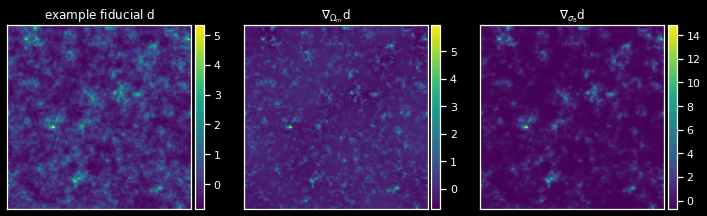

In [ ]:
#@title visualize a fiducial universe and gradients <font color='lightgreen'>[run me]</font>
from imnn.utils import value_and_jacrev, value_and_jacfwd

def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, 
                                                        simulator_args=simulator_args)
cmap = 'viridis'
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(12,15))

im1 = ax[0].imshow(np.squeeze(simulation), 
                   extent=(0,1,0,1), cmap=cmap)
ax[0].title.set_text(r'example fiducial $\rm d$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[1].imshow(np.squeeze(simulation_gradient).T[0].T, 
                   extent=(0,1,0,1), cmap=cmap)
ax[1].title.set_text(r'$\nabla_{\Omega_m} \rm d$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[2].imshow(np.squeeze(simulation_gradient).T[1].T, 
                   extent=(0,1,0,1), cmap=cmap)
ax[2].title.set_text(r'$\nabla_{\sigma_8} \rm d$')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()

Nice ! Since we can differentiate our universe and power spectrum, we can easily compute gradients of a neural network's outputs with respect to simulation parameters. This will come in handy for compression training. 

---
## Training an IMNN


<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/imnn-scheme-white.png" alt="drawing" width="700"/>



The details behind the IMNN algorithm [can be found here on arxiv](https://arxiv.org/abs/1802.03537), but we'll summarize the gist briefly:



1.   We want to maximise the Fisher information, $\textbf{F}$, of compressed summaries to satisfy the Cramer-Rao bound:
    $$ \langle (\vartheta_\alpha - \langle \vartheta_\alpha \rangle )      (\vartheta_\beta - \langle \vartheta_\beta
    \rangle) \rangle \geq \textbf{F}^{-1}_{\alpha \beta} $$  which means saturating the Fisher information minimizes the average variance of the parameter estimates.

2.   To do this, and without loss of generality (proof coming soon!) we compute a Gaussian likelihood form to compute our Fisher information:
$$     -2 \ln \mathcal{L}(\textbf{x} | \textbf{d}) = (\textbf{x} - \boldsymbol{\mu}_f(\vartheta))^T \textbf{C}_f^{-1}(\textbf{x} - \boldsymbol{\mu}_f(\vartheta)) $$ where $\boldsymbol{\mu}_f$ and $\textbf{C}$ are the mean and covariance of the network output (summaries). The Fisher is then $$ \textbf{F}_{\alpha \beta} =  {\rm tr} [\boldsymbol{\mu}_{f,\alpha}^T C^{-1}_f \boldsymbol{\mu}_{f, \beta}] $$


Since we can differentiate through our neural network *and* simulated universe, we have the exact derivatives with respect to the pipeline we need to compute the Fisher matrix of compressed summaries on-the-fly during compression training. 
___

### Q: wait -- what if my simulator isn't differentiable ?
We don't *need* to have the exact derivatives for IMNN training ! Having the gradients accessible just means that we don't have to optimize finite-differencing for estimating derivatives by hand, however (as is done in the original IMNN paper).



___


Let's use an IMNN trained on cosmological fields to see how much information we can extract an what sort of constraints we can get. We will use 2000 simulations to estimate the covariance and use all of their derivatives and we'll summarise the whole cosmological field using 2 summaries.

In [13]:
n_s = 200     # number of simulations used to estimate covariance of network outputs
n_d = n_s     # number of simulations used to estimate the numerical derivative of
              # the mean of the network outputs
n_summaries = 2

We're going to use a fully convolutional inception network built using stax with some custom designed blocks. The inception block itself is implemented in the following block:

In [14]:
#@title nn model stuff <font color='lightgreen'>[RUN ME]</font>
def InceptBlock(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    conv1x1 = stax.serial(stax.Conv(filters1, (1, 1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1, 1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3, 3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1, 1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5, 5), strides, padding="SAME")) 
    
    maxpool = stax.serial(stax.MaxPool((3, 3), padding="SAME"),
                         stax.Conv(filters4, (1, 1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
    else:
        return stax.serial(
              stax.FanOut(2),
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)

We'll also want to make sure that the output of the network is the correct shape, for which we'll introduce a Reshaping layer

In [15]:
def Reshape(shape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (shape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs, shape)
    return init_fun, apply_fun

Now we can build the network, with 55 filters and strides of 4 in each direction in each layer

In [16]:
fs = 55
layers = [
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(2, 2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1, 1), strides=(1, 1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))    
]
model = stax.serial(*layers)

We'll also introduce a function to check our model output:

In [17]:
def print_model(layers, input_shape, rng):
    print('input_shape: ', input_shape)
    for l in range(len(layers)):
        _m = stax.serial(*layers[:l+1])
        print('layer %d shape: '%(l+1), _m[0](rng, input_shape)[0])

# print model specs
key,rng = jax.random.split(rng)
input_shape = (1,) + shape + (1,)

print_model(layers, input_shape, rng)

input_shape:  (1, 128, 128, 1)
layer 1 shape:  (1, 32, 32, 220)
layer 2 shape:  (1, 8, 8, 220)
layer 3 shape:  (1, 2, 2, 220)
layer 4 shape:  (1, 1, 1, 110)
layer 5 shape:  (1, 1, 1, 2)
layer 6 shape:  (1, 2)
layer 7 shape:  (2,)


We'll also grab an adam optimiser from jax.experimental.optimizers

In [18]:
optimiser = optimizers.adam(step_size=1e-3)

Note that due to the form of the network we'll want to have simulations that have a "channel" dimension, which we can set up by not allowing for squeezing in the simulator.

### Load an IMNN

Finally we can load a pre-trained IMNN and compare its compression efficiency to the theoretical Fisher. We will pull the weights and state from the parent repository and calculate the compressor statistics.

We've used a SimulatorIMNN trained on new simulations on-the-fly, eliminating the need for a validation dataset. If you're interested in the IMNN training, see the [benchmarking Colab notebook](https://colab.research.google.com/drive/1_y_Rgn3vrb2rlk9YUDUtfwDv9hx774ZF#scrollTo=EW4H-R8I0q6n) or the Bonus challenge at the end of this tutorial.

We're not training an IMNN here because this model takes $\approx 50$ minutes and requires elevated Colab Pro resources.


In [244]:
!git clone https://github.com/tlmakinen/FieldIMNNs.git

Cloning into 'FieldIMNNs'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 324 (delta 130), reused 265 (delta 74), pack-reused 0
Receiving objects: 100% (324/324), 63.22 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [245]:
# load IMNN state
import cloudpickle as pickle
import os

def unpickle_me(path):
        file = open(path, 'rb')
        return pickle.load(file)


folder_name = './FieldIMNNs/tutorial/IMNN-aspects/'
loadstate = unpickle_me(os.path.join(folder_name, 'IMNN_state'))
state = jax.experimental.optimizers.pack_optimizer_state(loadstate)

startup_key = np.load(os.path.join(folder_name, 'IMNN_startup_key.npy'), allow_pickle=True)

# load weights to set the IMNN
best_weights = np.load(os.path.join(folder_name, 'best_w.npy'), allow_pickle=True)

In [246]:
# initialize IMNN with pre-trained state
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1,) + shape + (1,),
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=state,  # <---- initialize with state
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}}))

`simulator` provided, using SimulatorIMNN


In [247]:
# now set weights using the best training weights and startup key (this can take a moment)
IMNN.set_F_statistics(w=best_weights, key=startup_key)

In [248]:
print('det F from IMNN:', np.linalg.det(IMNN.F))

det F from IMNN: 594450.7


In [51]:
print('% Fisher information captured by IMNN compared to theory: ', np.linalg.det(IMNN.F) / 656705.6827) 

% Fisher information captured by IMNN compared to theory:  0.9052011


### if you want to check out how to train an IMNN, see the end of the tutorial !

---
# Inference on a target cosmological field

Now that we have a trained compression function (albeit at a somewhat arbitrary fiducial model), we can now perform simulation-based inference with the optimal summaries. 

We'll now pretend to "observe" a cosmological density field at some target parameters, $\theta_{\rm target}$. We'll select $\Omega_c=0.25$ and $\sigma_8=0.81$ (measured 2015 Planck parameters). To get started with this tutorial, we'll load a pre-generated field from the GitHub ("field 2" from our paper !), but you can always generate a new realization with the simulator code.

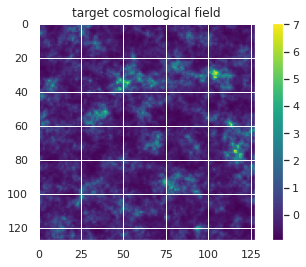

In [74]:
θ_target = np.array([jc.Planck15().Omega_c, jc.Planck15().sigma8,])

δ_target = np.load('./FieldIMNNs/tutorial/target_field_planck.npy')

sns.set() # set up plot settings
cmap='viridis'
plt.imshow(δ_target, cmap=cmap)
plt.colorbar()
plt.title('target cosmological field')
plt.show()

Now we're going to **forget we ever knew our choice of target parameters** and do inference on this target data as if it were a real observation (minus measurement noise for now, of course !)

## Inference

We can now attempt to do inference of some target data using the IMNN. 

First we're going to compress our target field down to parameter estimates using the IMNN method `IMNN.get_estimate(d)`. What this code does is returns the score estimator for the parameters, obtained via the transformation        
$$ \hat{\theta}_{\alpha} = \theta^{\rm fid}_\alpha + \textbf{F}^{-1}_{\alpha \beta} \frac{\partial \mu_i}{\partial \theta_\beta} \textbf{C}^{-1}_{ij} \textbf({x}(\textbf{w}, \textbf{d}) - {\mu})_j $$
where ${x}(\textbf{w}, \textbf{d})$ are the network summaries.


In [75]:
estimates = IMNN.get_estimate(np.expand_dims(δ_target, (0, 1, -1)))
print('IMNN parameter estimates:', estimates)

IMNN parameter estimates: [[0.31959814 0.7647977 ]]


The cool thing about training an IMNN is that it *automatically* gives you a simple uncertainty estimate on the parameters of interest via the optimal Fisher matrix. We can make a Gaussian approximation to the likelihood using the inverse of the matrix.

Note that to demonstrate robustness, the fiducial parameter values are deliberately far from the target parameters that this estimate of the Fisher information as the covariance will likely be misleading. 

We'll need to select a prior distribution first. We'll do this in `tfpj`, selecting wide uniform priors for both $\Omega_c$ and $\sigma_8$.

In [76]:
prior = tfpj.distributions.Blockwise(
    [tfpj.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.01, 0.2], [1.0, 1.3])])
prior.low = np.array([0.01, 0.])
prior.high = np.array([1.0, 1.3])

Then we can use the IMNN's built-in Gaussian approximation code:

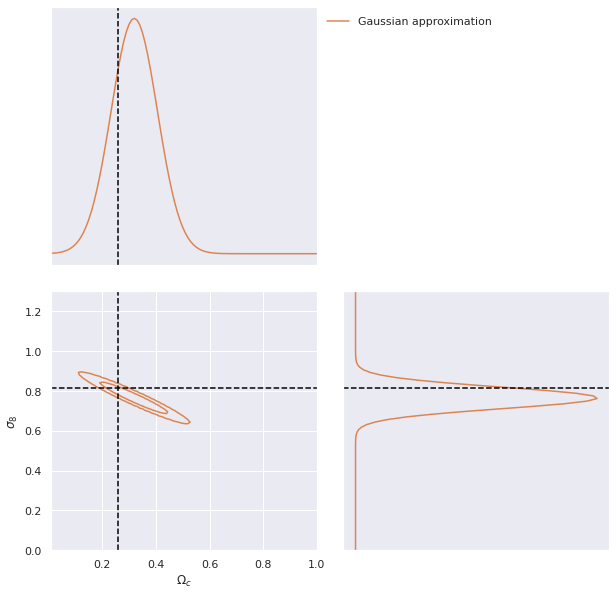

In [77]:
sns.set()
GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=estimates, 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)
ax = GA.marginal_plot(
    known=θ_target,          
    label="Gaussian approximation",           
    axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
    colours="C1");

Even though our fiducial model was trained far away $(\Omega_c, \sigma_8) = (0.4, 0.6)$, our score esimates (center of our ellipse) are very close to the target Planck (crosshairs).

we now have a compression and informative summaries of our target data. We'll next proceed to setting up density estimation to construct our posteriors !


___
# Posterior Construction with DELFI

Density Estimation Likelihood-Free Inference (DELFI) is presented formally [here on arxiv](https://arxiv.org/abs/1903.00007), but we'll give you the TLDR here:

Now that we have nonlinear IMNN summaries, $\textbf{x}$, to describe our cosmological fields, we can perform density estimation to model the *summary data likelihood*, $p(\textbf{x} | \boldsymbol{\theta})$. Once we have this, we can obtain the posterior distribution for $\boldsymbol{\theta}$ via Bayes' rule:
$$ p(\boldsymbol{\theta} | \textbf{x}) \propto  p(\textbf{x} | \boldsymbol{\theta}) p(\boldsymbol{\theta}) $$.

## What are CMAFs ?


DELFI provides Conditional Masked Autoregressive Flows (CMAFs) are stacks of neural autoencoders carefully masked to parameterize the summary-parameter likelihood. To start, note that any probability density can be factored as a product of one-dimensional conditional distributions via the chain rule of probability:
\begin{equation}
    p(\textbf{x} | \boldsymbol{\theta}) = \prod_{i=1}^{\dim(\textbf{x})} p({\rm x}_i | \textbf{x}_{1:i-1}, \boldsymbol{\theta})
\end{equation}
Masked Autoencoders for density estimation (MADE) model each of these one-dimensional conditionals as Gaussians with mean and variance parameters parameterized by neural network weights, $\textbf{w}$. The neural network layers are masked in such a way that the autoregressive property is preserved, e.g. the output nodes for the density $p({\rm x}_i | \textbf{x}_{1:i-1}, \boldsymbol{\theta})$ *only* depend on $\textbf{x}_{1:i-1}$ and $\boldsymbol{\theta}$, satisfying the chain rule.


We can then stack a bunch of MADEs to form a neural flow for our posterior !
![delfi-graphic](https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/delfi-made.png)



What we're going to do is 

1.   Train a Conditional Masked Autoregressive Flow to parameterize $p(\textbf{x} | \boldsymbol{\theta})$ to minimize the log-probability, $-\ln U$.
2.   Use an affine MCMC sampler to draw from the posterior at the target summaries, $\textbf{x}^{\rm target}$
3. Append training data from the posterior and re-train MAFs.



In [78]:
!pip install -q getdist
!pip install -q corner
!pip install -q chainconsumer

import keras
import tensorflow.keras.backend as K

import time
from tqdm import tqdm
from chainconsumer import ChainConsumer

     |████████████████████████████████| 778kB 15.4MB/s 
     |████████████████████████████████| 28.5MB 1.5MB/s 
     |████████████████████████████████| 645kB 56.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 51kB 5.8MB/s 


(ignore the red error message)

We'll set up the same prior as before, this time in regular `tensorflow-probability`. This means that our CMAFs can talk to our prior draws in the form of tensorflow tensors.

In [79]:
# set up prior in non-jax tfp
samp_prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.01, 0.2], [1.0, 1.3])])
samp_prior.low = np.array([0.01, 0.])
samp_prior.high = np.array([1.0, 1.3])

In [80]:
#@title set up the CMAF code <font color='lightgreen'>[RUN ME]</font>
class ConditionalMaskedAutoregressiveFlow(tf.Module):
    def __init__(self, n_dimensions=None, n_conditionals=None, n_mades=1, n_hidden=[50,50], input_order="random",
    activation=keras.layers.LeakyReLU(0.01), 
    all_layers=True,
    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None), 
    bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
    kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None,
    bias_constraint=None):
        super(ConditionalMaskedAutoregressiveFlow, self).__init__('hi')
        # extract init parameters
        self.n_dimensions = n_dimensions
        self.n_conditionals = n_conditionals
        self.n_mades = n_mades
        # construct the base (normal) distribution
        self.base_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros(self.n_dimensions), scale_diag=tf.ones(self.n_dimensions))
        # put the conditional inputs to all layers, or just the first layer?
        if all_layers == True:
            all_layers = "all_layers"
        else:
            all_layers = "first_layer"
        # construct stack of conditional MADEs
        self.MADEs = [tfb.AutoregressiveNetwork(
                        params=2,
                        hidden_units=n_hidden,
                        activation=activation,
                        event_shape=[n_dimensions],
                        conditional=True,
                        conditional_event_shape=[n_conditionals],
                        conditional_input_layers=all_layers,
                        input_order=input_order,
                        kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer,
                        kernel_regularizer=kernel_regularizer,
                        bias_regularizer=bias_regularizer,
                        kernel_constraint=kernel_constraint,
                        bias_constraint=bias_constraint,
                        ) for i in range(n_mades)
        ]
    # bijector for x | y (chain the conditional MADEs together)
    def bijector(self, y):
        # start with an empty bijector
        MAF = tfb.Identity() 
        # pass through the MADE layers (passing conditional inputs each time)
        for i in range(self.n_mades):
            MAF = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=lambda x: self.MADEs[i](x, conditional_input=y))(MAF)
        return MAF
    # construct distribution P(x | y)
    def __call__(self, y):
        return tfd.TransformedDistribution(
            self.base_distribution,
            bijector=self.bijector(y))
    # log probability ln P(x | y)
    def log_prob(self, x, y):
        return self.__call__(y).log_prob(x)
    # sample n samples from P(x | y)
    def sample(self, n, y):
        # base samples
        base_samples = self.base_distribution.sample(n)
        # biject the samples
        return self.bijector(y).forward(base_samples)

If you're curious about how the MCMC sampler and CMAF code work, feel free to double-click the hidden cells above. We'll walk through the gist of how each module works though:

The `ConditionalMaskedAutoregressiveFlow` API functions similarly to other `tfp` distributions. To set up a model we need to choose a few aspects of the flow. We first need to choose how many MADEs we want to stack to form our flow, `n_mades`. To set up a model with three MADEs, two parameters (`n_dimensions`) and two conditionals (`n_conditionals`), and two hidden layers of 50 neurons per MADE, we'd call:

        my_CMAF = ConditionalMaskedAutoregressiveFlow(n_dimensions=2, n_conditionals=2, n_mades=3, n_hidden=[50,50])


What's cool is that this module works just like a `tfp.distributions` function, which means that we can call a log-probability, $p(x | y)$ *conditional* on some $y$-value:

        key,rng = jax.random.split(rng)
        n_samples = 1
        x = prior.sample(sample_shape=(n_samples,), seed=key)
        y = np.array([0.3, 0.4])
        logU = my_CMAF.log_prob(x, y)

We're going to work with this basic syntax to set up useful DELFI dictionaries to store useful aspects.

___
# Exercise 0: initialize models for target data

Now we're going to initialize several CMAF models for our piece of target data. Using multiple (and varied) deep learning architectures for the same problem is called the "deep ensemble" technique ([see this paper for an overview](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf)).

When setting up DELFI, it's important to remember that each ensemble of CMAFs ought to be generated *per piece of target data*, since we're interested in observing the "slice" of parameter space that gives us each datum's posterior. Since these models are written in Tensorflow, we don't have to worry about specifying a random key or initialization for the model like we do in `Jax`.


1. Declare a `DELFI` dictionary to store the following aspects:
   - a list of CMAF models
   - a list of optimizers
   - a training dataset
   - a validation dataset
   - the IMNN estimates

2. Initialize `num_models=2` models, each with `n_mades=3` MADEs. Try one set of MADEs with two layers of 50 neurons, and another with three layers. See if you can set up their respective optimizers (we'll use `tf.keras.optimizers.Adam()` with a learning rate of $10^-3$.


 ## note: remove all `pass` arguments to functions to make them runnable !

In [ ]:
DELFI = {
    
}

In [211]:
#@title Ex. 0 solution <font color='lightgreen'>[run me to proceed]</font>
num_targets = 1
# set up list of dictionaries for the target datum
DELFI = {
    'MAFs': None,        # list of CAMF models
    'opts': [],          # list of optimizers
    'posts':[],          # list of MAF posteriors
    'train_data': None,  # training dataset
    'val_data': None,    # validation dataset
    'train_losses' : [], # losses
    'val_losses' : [],
    'estimates': estimates,
    'target_data' : δ_target,
    'F_IMNN': IMNN.F,
    'θ_target': θ_target,
}


# number of CMAFs per DELFI ensemble
num_models = 2
n_hiddens = [[50,50], [50,50]] # try different architectures



DELFI['MAFs'] = [ConditionalMaskedAutoregressiveFlow(n_dimensions=2, n_mades=3,
                          n_conditionals=2, n_hidden=n_hiddens[i]) for i in range(num_models)]

DELFI['opts'] = [tf.keras.optimizers.Adam(learning_rate=1e-3) for i in range(num_models)]

___
# Exercise 1: define train and validation steps

Here we want to define tensorflow function training and validation steps that we'll later call in a loop to train each CMAF model in the DELFI ensemble. 

1. set up the log posterior loss: $-\ln U = -\ln p(x | y) - \ln p(y)$ where $y=\theta$ are our parameters.

    *hint*: try the `samp_prior.log_prob()` call on a few data
2. obtain gradients, `grads` with respect to the scalar loss
3. update each optimizer with the call `optimizer.apply_gradients(zip(grads, model.trainable_variables)`


In [117]:
# define loss function -ln U
def logloss(x, y, model, prior):
    pass

In [212]:
#@title Ex. 1 solution <font color='lightgreen'>[run me to proceed]</font>
# define loss function
def logloss(x, y, model):
    return - model.log_prob(x,y) - samp_prior.log_prob(y)

Now that we have our loss defined, we can use it to train our CMAFs via backpropagation:

In [213]:
@tf.function
def train_step(x, y, ensemble, opts):
    losses = []

    # loop over models in ensemble
    for m in range(len(ensemble)):
        with tf.GradientTape() as tape:

            # get loss across batch using our log-loss function
            loss = K.mean(logloss(x, y, ensemble[m]))
            losses.append(loss)

        grads = tape.gradient(loss, ensemble[m].trainable_variables)
        opts[m].apply_gradients(zip(grads, ensemble[m].trainable_variables))

    return losses

@tf.function
def val_step(x, y, ensemble):
    val_l = []
    for m in range(len(ensemble)):
        loss = K.mean(logloss(x, y, ensemble[m]))
        val_l.append(loss)
    return val_l


___

# Exercise 2: create some dataset functions
Here we want to create the dataset of $(\textbf{x}, \boldsymbol{\theta})$ pairs to train our CMAFs on. Write a function that:
1. generate simulations (with random keys) from sampled parameter pairs, $\theta$. We've set up the key-splitting and simulator code for you.
2. feed simulations through `IMNN.get_estimate()` to get summaries, $\textbf{x}$
3. try to use `jax.vmap()` the above to do this efficiently ! 


In [ ]:
#@title hints for vmapping:
# for a function `my_fn(a, x)`, you can vmap, "vector map" over a set of array values as follows:

def my_fn(x, a, b):
  return a*x**3 - x + b

# define a slope and intercept
a = 0.5
b = 1.0
# define our x-values
x = np.linspace(-10,10, num=100)

# define a mini function that only depends on x
mini_fn = lambda x: my_fn(x, a=a, b=b)

y = jax.vmap(mini_fn)(x)
plt.plot(x, y)
plt.xlabel('$x$')
plt.ylabel('$y$')
        

In [214]:
def get_params_summaries(key, θ_samp, simulator=simulator):
    """
    function for generating (x,θ) pairs from IMNN compression
    over the prior range
    θ_samp: array of sampled parameters over prior range
    simulator: function for simulating data to be compressed
    """

    n_samples = θ_samp.shape[0]

    # we'll split up the keys for you
    keys = np.array(jax.random.split(key, num=n_samples))

    # next define a simulator that takes a key as argument
    my_simulator = lambda rng, θ: simulator(
                            rng, θ, simulator_args={
                                **simulator_args, 
                                **{"squeeze": False}})
    
    # generate data, vmapping over the random keys and parameters:
    # d =

    # generate summaries
    # x = 

    # return paired training data
    pass


In [215]:
#@title Ex. 2 solution <font color='lightgreen'>[run me to proceed]</font>

def get_params_summaries(key, n_samples, θ_samp, simulator=simulator):
    keys = np.array(jax.random.split(key, num=n_samples))
    sim = lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}})
    
    # generate a bunch of fields over the prior ranges
    d = jax.vmap(sim)(keys, θ_samp)
    
    # compress fields to summaries
    x = IMNN.get_estimate(d)

    return x, θ_samp

In [216]:
def get_dataset(data, batch_size=20, buffer_size=1000, split=0.75):
    """ 
    helper function for creating tensorflow dataset for CMAF training.
    data: pair of vectors (x, θ) = (x, y)
    batch_size: how many data pairs per gradient descent
    buffer_size: what chunk of the dataset to shuffle (default: random)
    split: train-validation split
    """
    x,y = data

    idx = int(len(x)*split)
    x_train = x[:idx]
    y_train = y[:idx]  
    x_val = x[idx:]
    y_val = y[idx:]

    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset

# Visualize compressed summaries at fiducial model and over the prior 

Now that we a function that can take in parameter vectors, generates simulations, and then compresses them into summaries, we can visualize how the IMNN compresses the fields in summary space. We will visualize:
1. compressed simulations run at the fiducial model ($\Omega_c, \sigma_8)$ = (0.4, 0.6)
2. compressed simulations at the target model ($\Omega_c, \sigma_8)$ = (0.2589, 0.8159)
3. compressed simulations run across the full (uniform) prior range

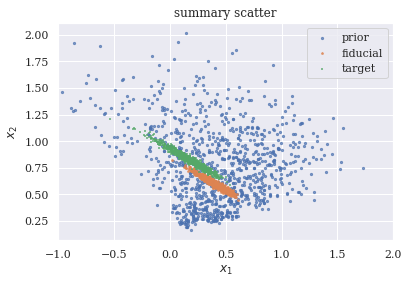

In [217]:
n_samples = 1000
buffer_size = n_samples
key1,key2 = jax.random.split(rng)

# params over the prior range
θ_samp = prior.sample(sample_shape=(n_samples,), seed=key1)
xs, θ_samp = get_params_summaries(key2, n_samples, θ_samp)

# fiducial params
key,rng = jax.random.split(key1)
_θfids = np.repeat(np.expand_dims(θ_fid, 1), 1000, axis=1).T
xs_fid, _ = get_params_summaries(key, n_samples, _θfids)

# target params
_θtargets = np.repeat(np.expand_dims(θ_target, 1), 1000, axis=1).T
xs_target, _ = get_params_summaries(key, n_samples, _θtargets)


plt.scatter(xs.T[0], xs.T[1], label='prior', s=5, alpha=0.7)
plt.scatter(xs_fid.T[0], xs_fid.T[1], label='fiducial', s=5, marker='*', alpha=0.7)
plt.scatter(xs_target.T[0], xs_target.T[1], label='target', s=5, marker='+', alpha=0.7)

plt.title('summary scatter')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-1.0, 2.0)
plt.legend()
plt.show()

### Q: Wait, why is our prior in summary space not uniform (rectangular) ?
Remember, we've passed our parameters through our simulator, and our simulations through the IMNN compressor, meaning our summaries are nonlinear (weirdly-shaped). These score estimates obtained from the IMNN is are quick and convenient, but can be biased and suboptimal if the fiducial model is far from the truth.

Even then, these IMNN score summaries can be used for likelihood-free inference to give consistent posterior estimates, albeit with some information loss (since we haven't compressed near the target).


---
## Now, onto the good bit--CMAF training !

### Generate our training dataset
We're going to call our dataset functions to create a dataset of $(\textbf{x}, \boldsymbol{\theta})$ of shape $((1000, 2), (1000, 2))$.

In [218]:
n_samples = 1000
batch_size = 100
buffer_size = n_samples
key1,key2 = jax.random.split(rng)

# sample from the tfpj prior so that we can specify the key
# and stay in jax.numpy:
θ_samp = prior.sample(sample_shape=(n_samples,), seed=key1)

# generate sims and compress to summaries
ts, θ_samp = get_params_summaries(key2, n_samples, θ_samp)
data = (ts, θ_samp)

# use the dataset function
train_dataset, val_dataset = get_dataset(data, batch_size=batch_size, buffer_size=buffer_size)
DELFI['train_dataset'] = train_dataset
DELFI['val_dataset'] = val_dataset

Next let's define a training loop for a set number of epochs, calling our training and validation step functions.

___

# Exercise 3: define training loop
We're going to use the `train_step` functions to train our CMAF models for a set number of epochs.

In [219]:
def training_loop(delfi, epochs=2000):
    """training loop function that updates optimizers and
    stores training history"""

    # unpack our dictionary's attributes
    ensemble = delfi['MAFs']
    opts = delfi['opts']
    train_dataset = delfi['train_dataset']
    val_dataset = delfi['val_dataset']

    for epoch in tqdm(range(epochs)):

      # shuffle training data anew every 50th epoch (done for you)
      if epoch % 50 == 0:
          train_dataset = train_dataset.shuffle(buffer_size=buffer_size)

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
          # 1) call train step and capture loss value
          pass
      # 2) store loss value

      # Run a validation loop at the end of each epoch.
      for x_batch_val, y_batch_val in val_dataset:
          # 3) call val step and capture loss value
          pass
      # 4) store validation loss value

      pass


In [220]:
#@title Ex. 3 solution <font color='lightgreen'>[run me to proceed]</font>
def training_loop(delfi, epochs=2000):
    """training loop function that updates optimizers and
    stores training history"""

    # unpack our dictionary's attributes
    ensemble = delfi['MAFs']
    opts = delfi['opts']
    train_dataset = delfi['train_dataset']
    val_dataset = delfi['val_dataset']

    for epoch in tqdm(range(epochs)):

      # shuffle training data anew every 50th epoch
      if epoch % 50 == 0:
          train_dataset = train_dataset.shuffle(buffer_size=buffer_size)

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
          # call train step and capture loss value
          loss_values = train_step(x_batch_train, y_batch_train, ensemble, opts)

      # store loss value
      delfi['train_losses'].append(loss_values)

      # Run a validation loop at the end of each epoch.
      for x_batch_val, y_batch_val in val_dataset:
          # call val step and capture loss value
          val_loss = val_step(x_batch_val, y_batch_val, ensemble)

      # store validation loss value
      delfi['val_losses'].append(val_loss)

In [221]:
#@title define some useful plotting functions <font color='lightgreen'>[run me]</font>
# visualize training trajectories
def plot_trajectories(delfis, num_models=4, num_targets=4):
    """code for plotting training trajectories. note that num_targets should be
    equal to len(delfis)"""


    if num_targets > 1:
      fig,axs = plt.subplots(ncols=num_models, nrows=num_targets, figsize=(8,8))

      for i,d in enumerate(delfis):
        for j in range(num_models):
          axs[i,j].plot(np.array(d['train_losses']).T[j], label='train')
          axs[i,j].plot(np.array(d['val_losses']).T[j], label='val')

          if j == 0:
            axs[i,j].set_ylabel(r'$p(t\ |\ \vartheta; w)$')
          
          if i == num_models-1:
            axs[i,j].set_xlabel(r'num epochs')

    else:
      fig,axs = plt.subplots(ncols=num_models, nrows=num_targets, figsize=(7,3))
      d = delfis
      for j in range(num_models):
          axs[j].plot(np.array(d['train_losses']).T[j], label='train')
          axs[j].plot(np.array(d['val_losses']).T[j], label='val')

          if j == 0:
            #axs[j].set_ylabel(r'$p(t\ |\ \vartheta; w)$')
            axs[j].set_ylabel(r'$-\ln U$')

          axs[j].set_xlabel(r'num epochs')

          axs[j].set_title('CMAF model %d'%(j + 1))
          # if i == num_models-1:
          #   axs[j].set_xlabel(r'\# epochs')


    plt.legend()
    plt.tight_layout()
    plt.show()


# then visualize all posteriors
def plot_posts(delfis, params, num_models=4, num_targets=4, 
               Fisher=None, estimates=estimates, truth=None):
    fig,ax = plt.subplots(ncols=num_models, nrows=num_targets, figsize=(7,4))
    params = [r'$\Omega_c$', r'$\sigma_8$']

    if num_targets > 1:
      for i,delfi in enumerate(delfis):
        for j in range(num_models):
          cs = ChainConsumer()
          cs.add_chain(delfi['posts'][j], parameters=params, name='DELFI + IMNN') #, color=corner_colors[0])
          #cs.add_covariance(θ_target, -Finv_analytic, parameters=params, name="Analytic Fisher", color=corner_colors[2])
          cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
                  shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8)
          cs.plotter.plot_contour(ax[i, j], r"$\Omega_c$", r"$\sigma_8$")

          ax[i, j].axvline(θ_target[0], linestyle=':', linewidth=1)
          ax[i, j].axhline(θ_target[1], linestyle=':', linewidth=1)

          ax[i,j].set_ylim([prior.low[1], prior.high[1]])
          ax[i,j].set_xlim([prior.low[0], prior.high[0]])

    else:
      delfi = delfis
      for j in range(num_models):
          cs = ChainConsumer()
          cs.add_chain(delfi['posts'][j], parameters=params, name='DELFI + IMNN')
          if Fisher is not None:
            cs.add_covariance(np.squeeze(estimates), np.linalg.inv(Fisher), 
                              parameters=params, name="Fisher", color='k')
          cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
                  shade=[True, False, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8)
          cs.plotter.plot_contour(ax[j], r"$\Omega_c$", r"$\sigma_8$")

          if truth is not None:
            ax[j].axvline(truth[0], linestyle=':', linewidth=1, color='k')
            ax[j].axhline(truth[1], linestyle=':', linewidth=1, color='k')

          ax[j].set_ylim([prior.low[1], prior.high[1]])
          ax[j].set_xlim([prior.low[0], prior.high[0]])

          ax[j].set_xlabel(params[0])
          ax[j].set_ylabel(params[1])

          ax[j].set_title('CMAF model %d'%(j+1))

    plt.legend()
    plt.tight_layout()
    plt.show()
    return ax



### train our CMAF models !

In [222]:
# train both models with the training loop
epochs = 2000
training_loop(DELFI, epochs=epochs)

100%|██████████| 2000/2000 [02:43<00:00, 12.25it/s]


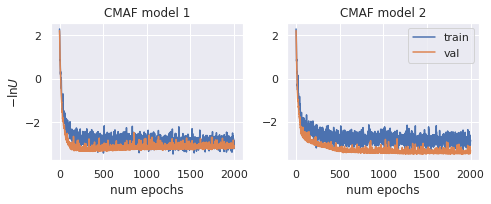

In [223]:
# visualize training trajectories
import seaborn as sns
%matplotlib inline
sns.set_theme()
plot_trajectories(DELFI, num_models=2, num_targets=1)

# Exercise 4: using the affine MCMC sampler
Now that we have trained CMAF models with which to compute $p(x | \theta)$, we now need to set up an efficient MCMC sampler to draw from the posterior, $p(x | \theta) \times p(\theta)$. We can do this using the `affine_sample()` sampler, included in `pydelfi` package. This code is written in Tensorflow, adapted from the [`emcee` package](https://arxiv.org/abs/1202.3665), and can be called with only a few lines of code:

        # initialize walkers...
        walkers1 = tf.random.normal([n_walkers, 2], (a, b), sigma)
        walkers2 = tf.random.normal([n_walkers, 2], (a, b), sigma)

        # sample using affine
        chains = affine_sample(log_prob, n_params, n_walkers, n_steps, walkers1, walkers2)

1. First we'll need to set up our log-probability for the posterior. Write a function `log_posterior()` that returns a probability given $x$ and a conditional $y$:

      

In [130]:
#@title set up the affine MCMC sampler <font color='lightgreen'>[run me]</font>
from tqdm import trange
import numpy as onp

def affine_sample(log_prob, n_params, n_walkers, n_steps, walkers1, walkers2):
    
    # initialize current state
    current_state1 = tf.Variable(walkers1)
    current_state2 = tf.Variable(walkers2)
    

    # initial target log prob for the walkers (and set any nans to -inf)...
    logp_current1 = log_prob(current_state1)
    logp_current2 = log_prob(current_state2)
    logp_current1 = tf.where(tf.math.is_nan(logp_current1), tf.ones_like(logp_current1)*tf.math.log(0.), logp_current1)
    logp_current2 = tf.where(tf.math.is_nan(logp_current2), tf.ones_like(logp_current2)*tf.math.log(0.), logp_current2)

    # holder for the whole chain
    chain = [tf.concat([current_state1, current_state2], axis=0)]
    
    # MCMC loop
    with trange(1, n_steps) as t:
        for epoch in t:

            # first set of walkers:

            # proposals
            partners1 = tf.gather(current_state2, onp.random.randint(0, n_walkers, n_walkers))
            z1 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
            proposed_state1 = partners1 + tf.transpose(z1*tf.transpose(current_state1 - partners1))
            

            # target log prob at proposed points
            logp_proposed1 = log_prob(proposed_state1)
            logp_proposed1 = tf.where(tf.math.is_nan(logp_proposed1), tf.ones_like(logp_proposed1)*tf.math.log(0.), logp_proposed1)

            # acceptance probability
            p_accept1 = tf.math.minimum(tf.ones(n_walkers), z1**(n_params-1)*tf.exp(logp_proposed1 - logp_current1) )

            # accept or not
            accept1_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept1)
            accept1 = tf.cast(accept1_, tf.float32)

            # update the state
            current_state1 = tf.transpose( tf.transpose(current_state1)*(1-accept1) + tf.transpose(proposed_state1)*accept1)
            logp_current1 = tf.where(accept1_, logp_proposed1, logp_current1)

            # second set of walkers:

            # proposals
            partners2 = tf.gather(current_state1, onp.random.randint(0, n_walkers, n_walkers))
            z2 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
            proposed_state2 = partners2 + tf.transpose(z2*tf.transpose(current_state2 - partners2))

            # target log prob at proposed points
            logp_proposed2 = log_prob(proposed_state2)
            logp_proposed2 = tf.where(tf.math.is_nan(logp_proposed2), tf.ones_like(logp_proposed2)*tf.math.log(0.), logp_proposed2)

            # acceptance probability
            p_accept2 = tf.math.minimum(tf.ones(n_walkers), z2**(n_params-1)*tf.exp(logp_proposed2 - logp_current2) )

            # accept or not
            accept2_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept2)
            accept2 = tf.cast(accept2_, tf.float32)

            # update the state
            current_state2 = tf.transpose( tf.transpose(current_state2)*(1-accept2) + tf.transpose(proposed_state2)*accept2)
            logp_current2 = tf.where(accept2_, logp_proposed2, logp_current2)

            # append to chain
            chain.append(tf.concat([current_state1, current_state2], axis=0))

    # stack up the chain
    chain = tf.stack(chain, axis=0)
    
    return chain


In [224]:
@tf.function
def log_posterior(x, y, cmaf):

  # define likelihood p(x|y) with CMAF

  # compute prior probability p(y)

  # return the log-posterior
  pass

In [225]:
#@title Ex. 4.1 solution <font color='lightgreen'>[run me to proceed]</font>
@tf.function
def log_posterior(x, y, cmaf):
  # define likelihood p(x|y) with CMAF
  like = cmaf.log_prob(x,y)
  # compute prior probability p(y)
  _prior = samp_prior.log_prob(y)

  return like + _prior # the log-posterior

2. Now we're going to use the sampler and write a function to obtain our posteriors. To call the sampler, we need to call our log-posterior function, as well as specify the number of walkers in parameter space:



In [226]:
# define function for getting posteriors
def get_posteriors(delfi, n_params, n_steps=2000, n_walkers=500, burnin_steps=1800, skip=4):
    delfi['posts'] = [] # reset posteriors (can save if you want to keep a record)

    # center affine sampler walkers on the IMNN estimates
    a,b = np.squeeze(delfi['estimates'])

    # choose width of proposal distribution
    # sigma = 

    # loop over models in the ensemble
    for m,cmaf in enumerate(delfi['MAFs']):
        print('getting posterior for target data with model %d'%(m+1))

        
        # wrapper for log_posterior function: freeze at target summary slice, x_target
        @tf.function
        def my_log_prob(y, x=delfi['estimates']):
            return log_posterior(x, y, cmaf)


        # initialize walkers...
        # walkers1 = 
        # walkers2 = 

        # sample using affine. note that this returns a tensorflow tensor
        # chain = affine_sample()

        # convert chain to numpy and append to dictionary
        delfi['posts'].append(np.stack([chain.numpy()[burnin_steps::skip,:,0].flatten(), 
                                        chain.numpy()[burnin_steps::skip,:,1].flatten()], axis=-1))
        
        pass

In [227]:
#@title Ex. 4.2 solution <font color='lightgreen'>[run me to proceed]</font>
# define function for getting posteriors
def get_posteriors(delfi, n_params, n_steps=2000, n_walkers=500, burnin_steps=1800, skip=4):
    delfi['posts'] = [] # reset posteriors (can save if you want to keep a record)

    # center affine sampler walkers on the IMNN estimates
    a,b = np.squeeze(delfi['estimates'])

    # choose width of proposal distribution
    sigma = 0.5 

    # loop over models in the ensemble
    for m,cmaf in enumerate(delfi['MAFs']):
        print('getting posterior for target data with model %d'%(m+1))

        
        # wrapper for log_posterior function: freeze at target summary slice
        @tf.function
        def my_log_prob(y, x=delfi['estimates']):
            return log_posterior(x, y, cmaf)


        # initialize walkers...
        walkers1 = tf.random.normal([n_walkers, 2], (a, b), sigma)
        walkers2 = tf.random.normal([n_walkers, 2], (a, b), sigma)

        # sample using affine
        chain = affine_sample(my_log_prob, n_params, n_walkers, n_steps, walkers1, walkers2)

        delfi['posts'].append(np.stack([chain.numpy()[burnin_steps::skip,:,0].flatten(), 
                                        chain.numpy()[burnin_steps::skip,:,1].flatten()], axis=-1))

In [228]:
# get all intermediate posteriors --> this should be really fast !
get_posteriors(DELFI, n_params)

getting posterior for target data with model 1


100%|██████████| 1999/1999 [00:16<00:00, 123.15it/s]


getting posterior for target data with model 2


100%|██████████| 1999/1999 [00:16<00:00, 123.63it/s]


We're going to use our plotting client to visualize our posteriors for each model. We'll also plot the IMNN's Fisher Gaussian Approximation in black, centered on our estimates. Finally, we'll display the true Planck parameters using crosshairs:

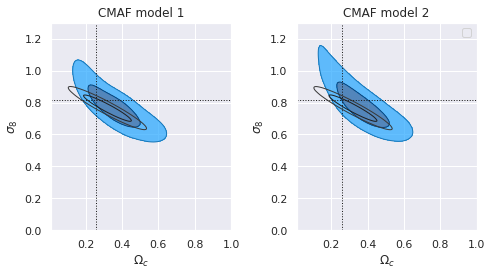

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b1df40e10>,
      dtype=object)

In [229]:
params = [r'$\Omega_c$', r'$\sigma_8$']
plot_posts(DELFI, params, num_models=num_models, num_targets=1, 
           Fisher=IMNN.F, estimates=np.squeeze(estimates), truth=θ_target)

___
# Exercise 5: append new posterior training data to hone in on the truth (repeat several times)

Finally, we're going to draw parameters from the posterior, re-simulate cosmological fields, compress, append the new ($x$, $\theta$) pairs to the dataset, and keep training our DELFI ensemble. Within a few iterations, this should shrink our posteriors considerably.

Since we've coded all of our training functions modularly, we can just run them in a loop (once we've drawn and simulated from the prior). First we'll give you a piece of code to draw from the posterior chains:

        concat_data(DELFI, key, n_samples=500)

Here, remember to re-set your random key for new samples !

Next, write a loop that:
1. draws `n_samples` summary-parameter pairs from *each* existing CMAF model's posteriors
2. continues training the DELFI ensemble members
3. re-samples the posterior

**bonus**: Can you develop a scheme that requires fewer `n_samples` draws each iteration ? What about optimizer stability ? (hint: try a decaying learning rate)
___

In [249]:
#@title `concat_data` function to draw from each posterior and concatenate dataset <font color='lightgreen'>[run me to proceed]</font>
import pandas as pd


def drop_samples(samples, prior=prior):
    """
    helper function for dropping posterior draws outside
    the specified prior range
    """
    mydf = pd.DataFrame(samples)

    mydf = mydf.drop(mydf[mydf[0] < prior.low[0]].index)
    mydf = mydf.drop(mydf[mydf[1] < prior.low[1]].index)
    mydf = mydf.drop(mydf[mydf[0] > prior.high[0]].index)
    mydf = mydf.drop(mydf[mydf[1] > prior.high[1]].index)

    return np.array(mydf.values, dtype='float32')


def concat_data(delfi, key, n_samples=500, prior=prior):
    """
    helper code for concatenating data for each DELFI CMAF model. 
    delfi: DELFI dictionary object with 'train_dataset' 
            and 'val_dataset' attributes
    key: jax.PRNGkey
    n_samples: number of samples to draw from EACH DELFI ensemble model
    """

    # take 500 samples from each posterior for each training data
    key,rng = jax.random.split(key)
    idx = np.arange(len(delfi['posts'][0]))

    ϑ_samp = []

    for m,_post in enumerate(delfi['posts']):
      ϑ_samp.append(_post[45000:][onp.random.choice(idx, size=n_samples)])

    ϑ_samp = np.concatenate(ϑ_samp, axis=0)

    print(ϑ_samp.shape)

    ϑ_samp = drop_samples(ϑ_samp, prior=prior)
    dropped = n_samples*len(delfi['posts']) - ϑ_samp.shape[0]

    print('I dropped {} parameter pairs that were outside the prior'.format(dropped))

    _n_samples = len(ϑ_samp)

    ts, ϑ_samp = get_params_summaries(key2, _n_samples, ϑ_samp)

    new_data = (ts, ϑ_samp)

    print("I've drawn %d new summary-parameter pairs"%(ts.shape[0]))

    # this should shuffle the dataset 
    new_train_dataset, new_val_dataset = get_dataset(new_data, batch_size=batch_size, buffer_size=len(new_data[0]))

    # concatenate datasets
    delfi['train_dataset'] = delfi['train_dataset'].concatenate(new_train_dataset)
    delfi['val_dataset'] = delfi['val_dataset'].concatenate(new_val_dataset)

doing retraining iteration 0
(1000, 2)
I dropped 1 parameter pairs that were outside the prior
I've drawn 999 new summary-parameter pairs
retraining on augmented dataset


100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


getting posterior for target data with model 1


100%|██████████| 1999/1999 [00:15<00:00, 129.90it/s]


getting posterior for target data with model 2


100%|██████████| 1999/1999 [00:15<00:00, 127.79it/s]


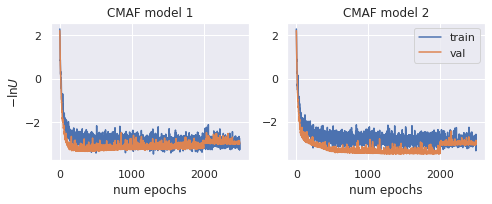

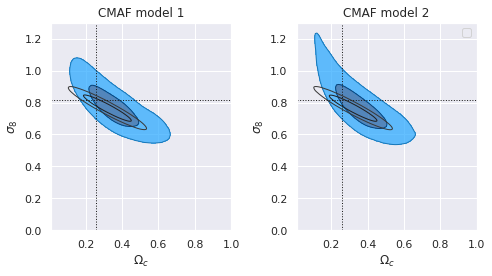

In [230]:
#@title Ex. 5 solution <font color='lightgreen'>[run me to proceed]</font>
for repeat in range(1):

    key,rng = jax.random.split(rng)
    print('doing retraining iteration %d'%(repeat))

    concat_data(DELFI, key, n_samples=500)
    
    print('retraining on augmented dataset')
    epochs = 500
    training_loop(DELFI, epochs=epochs)

    plot_trajectories(DELFI, num_models=2, num_targets=1)

    get_posteriors(DELFI, n_params)

    plot_posts(DELFI, params, num_models=num_models, num_targets=1, 
           Fisher=IMNN.F, estimates=np.squeeze(estimates), truth=θ_target)
    


___
# Exercise 6: create ensemble posterior
Once we're happy with the DELFI training, we can proceed to reporting our ensemble's combined posterior. Using the [`ChainConsumer` API](https://samreay.github.io/ChainConsumer/index.html), concatenate the posterior chains and report a nice corner plot:

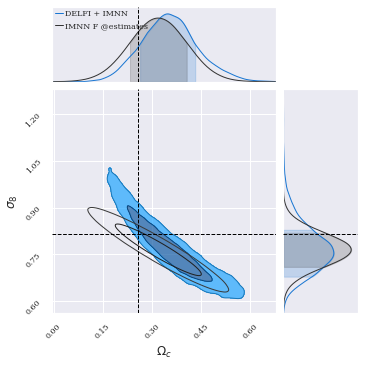

In [231]:
#@title Exercise 6 solution <font color='lightgreen'>[run me to proceed]</font>

def drop_samples(samples, prior=prior):
    """
    helper function for dropping posterior draws outside
    the specified prior range
    """
    mydf = pd.DataFrame(samples)

    mydf = mydf.drop(mydf[mydf[0] < prior.low[0]].index)
    mydf = mydf.drop(mydf[mydf[1] < prior.low[1]].index)
    mydf = mydf.drop(mydf[mydf[0] > prior.high[0]].index)
    mydf = mydf.drop(mydf[mydf[1] > prior.high[1]].index)

    return np.array(mydf.values, dtype='float32')

super_post = np.concatenate(DELFI['posts'], axis=0) 
# assign new dict entry after dropping samples outside the prior
DELFI['super_post'] = drop_samples(super_post)

params = [r"$\Omega_c$", r"$\sigma_8$"]
corner_colors = [None, None, 'k']



c = ChainConsumer()
c.add_chain(DELFI['super_post'][::10], parameters=params, name='DELFI + IMNN', color=corner_colors[0])
c.add_covariance(np.squeeze(estimates), IMNN.invF, parameters=params, name="IMNN F @estimates", color=corner_colors[2])

c.configure(linestyles=["-", "-", "--"], linewidths=[1.0, 1.0, 1.0,],
            shade=[True, False, False], shade_alpha=[0.7, 0.6, 0.],
            tick_font_size=8, usetex=False,
           legend_kwargs={"loc": "upper left", "fontsize": 8},
            legend_color_text=False, legend_location=(0, 0))

fig = c.plotter.plot(figsize="column", truth=list(θ_target), filename=None)

___
# Congrats !
You've made it through the core of the tutorial and trained a DELFI ensemble on IMNN-compressed summaries of mock dark matter fields and obtained cosmological parameter posteriors !

### Now what ? 
There are lots of things you can do if you have the time -- for one, you could check out the bonus problems below 

___
# BONUS: Compare IMNN Compressors

For this whole tutorial we've been using an IMNN ***trained deliberately far*** from our Planck parameters, meaning our compression isn't guaranteed to be optimal. In our accompanying paper (to be released on arXiv on July 16, 2021) we re-trained an IMNN on the mean of the score estimates of a set of four cosmological fields. Since this estimate is closer to the true target parameters, our IMNN compression is guaranteed to improve our inference on the target data.

<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/new-four-cosmo-field-comparison.png" alt="drawing" width="700"/>


We've included this newly-trained IMNN in the GitHub repository that you've already cloned into this notebook -- as a bonus, repeat the DELFI posterior estimation using the new (more optimal) compressor and see how your inference shapes up ! You *should* see tighter Gaussian Approximations *and* DELFI contours:

In [235]:
# load IMNN state
import cloudpickle as pickle
import os

def unpickle_me(path):
        file = open(path, 'rb')
        return pickle.load(file)


folder_name = './FieldIMNNs/tutorial/IMNN2-aspects/'
loadstate = unpickle_me(os.path.join(folder_name, 'IMNN_state'))
state2 = jax.experimental.optimizers.pack_optimizer_state(loadstate)

# startup key to get the right state of the weights
startup_key2 = np.load(os.path.join(folder_name, 'IMNN_startup_key.npy'), allow_pickle=True)

# load weights
best_weights2 = np.load(os.path.join(folder_name, 'best_w.npy'), allow_pickle=True)

# load fiducial model that we trained the model at (estimates derived from initial IMNN)
θ_fid_new = np.load(os.path.join(folder_name, 'new_fid_params.npy'), allow_pickle=True)

In [238]:
# initialize IMNN with pre-trained state
IMNN2 = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1,) + shape + (1,),
        θ_fid=θ_fid_new,
        model=model,
        optimiser=optimiser,
        key_or_state=state2,  # <---- initialize with state
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}}))

# now set weights using the best training weights and startup key (this can take a moment)
IMNN2.set_F_statistics(w=best_weights, key=startup_key2)

`simulator` provided, using SimulatorIMNN


In [239]:
print(np.linalg.det(IMNN2.F))

488718.5407332728


---
# BONUS 2:

Alternatively, train a new IMNN from scratch at the target data `estimates` (try with fewer filters on the free version of Colab). You could also try playing with other `stax` layers like `stax.Dense(num_neurons)`. Feel free to also switch up the simulation parameters -- choosing $N=32$ for instance will dramatically increase training speed for testing, etc.

In [ ]:
fs = 16
new_layers = [
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(2, 2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1, 1), strides=(1, 1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))    
]
new_model = stax.serial(*new_layers)

In [ ]:
print_model(layers, input_shape, rng)

In [ ]:
rng, key = jax.random.split(rng)
IMNN2 = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1,) + shape + (1,),
        θ_fid=np.squeeze(estimates),
        model=new_model,
        optimiser=optimiser,
        key_or_state=key,  # <---- initialize with key
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}}))

In [ ]:
print("now I'm training the IMNN")
rng, key = jax.random.split(rng)
IMNN2.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, 
         min_iterations=500, patience=100, best=True)

# visualize training trajectory
IMNN2.plot(expected_detF=None);